In [1]:
import pandas as pd

In [2]:
import pandas as pd
import spotipy

In [3]:
## Spotify secrets

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()
# did this work? commenting out so secrets are safe
# print(os.getenv('SPOTIFY_CLIENT_ID'))
# print(os.getenv('SPOTIFY_CLIENT_SECRET'))

True

In [5]:
client_id  = os.getenv('SPOTIFY_CLIENT_ID')
client_secret  = os.getenv('SPOTIFY_CLIENT_SECRET')

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

auth_manager = SpotifyClientCredentials(client_id,client_secret)
spotify = spotipy.Spotify(auth_manager = auth_manager)

In [7]:
## Full 2021 dataset of audio features


In [8]:
with open('../spotifyids21.txt') as f:
    links = f.readlines()

In [9]:
#let's chunk it into 100s at a time due to Spotify API limitation
def chunks_gen(list,n):
    for i in range(0, len(list), n):
        yield list[i:i+n]

In [10]:
chunks = list(chunks_gen(links,100))

for i in range(len(chunks)):
    chunks[i] = [x.replace('\n','') for x in chunks[i]]

In [11]:
af = pd.concat([pd.DataFrame([x for x in spotify.audio_features(tracks=chunks[i]) if x is not None]) 
                for i in range(0,len(chunks))],ignore_index=True).drop_duplicates() #have to drop duplicates since this is a weekly chart

In [12]:
af.columns.tolist()

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature']

In [13]:
af[af.speechiness == af.speechiness.max()] 
#anything above a 0.66 is considered to be a podcast or some sort of speaking rather than music so this seems right

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1197,0.582,0.537,0,-9.229,1,0.619,0.129,0.0,0.0749,0.771,82.103,audio_features,0nqhKXDjsyBMvbeWmgijD0,spotify:track:0nqhKXDjsyBMvbeWmgijD0,https://api.spotify.com/v1/tracks/0nqhKXDjsyBM...,https://api.spotify.com/v1/audio-analysis/0nqh...,180930,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F59DDE0520>]],
      dtype=object)

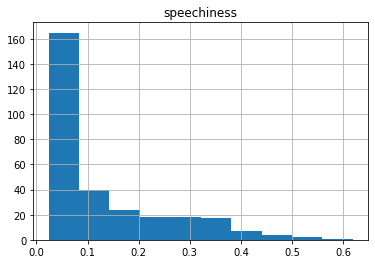

In [14]:
# af.speechiness.mean()
af.hist(column='speechiness')

In [15]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(af)
# profile

In [16]:
af[af.loudness == af.loudness.min()] 
#okay so 0 is the loudest and -60 is quietest

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1737,0.521,0.285,5,-14.619,0,0.105,0.936,0.000168,0.115,0.157,64.825,audio_features,2NJu5JtZLPmmuZF7Lr4Arr,spotify:track:2NJu5JtZLPmmuZF7Lr4Arr,https://api.spotify.com/v1/tracks/2NJu5JtZLPmm...,https://api.spotify.com/v1/audio-analysis/2NJu...,99680,3


### Vibe
        what's our vibe? a bop, upbeat, lots of bass, with some rap? (danceability, energy/tempo, loudness, speechiness)
tutorial here: https://www.python-graph-gallery.com/390-basic-radar-chart

In [17]:
#set up dataframe for radar chart
rdf = af.get(['danceability', 'energy', 'speechiness', 'tempo', 'loudness'])

In [18]:
# y axes need to be somewhat normalized
rdf.min(axis=0)
# rdf.max(axis=0)

danceability     0.2010
energy           0.2030
speechiness      0.0236
tempo           64.8250
loudness       -14.6190
dtype: float64

In [19]:
from sklearn.preprocessing import MinMaxScaler
# scales each feature to fit a 0-1 scale
data = (rdf.get(['tempo','loudness','speechiness']))
scaler = MinMaxScaler(clip=False)
print(scaler.fit(data))

MinMaxScaler()


In [20]:
print(scaler.data_max_)

[203.903  -2.491   0.619]


In [21]:
scaledy = pd.DataFrame(scaler.transform(data).tolist())

In [22]:
rdf = pd.concat([scaledy,rdf],axis=1,join='outer').drop(['tempo','loudness','speechiness'],axis=1).rename({0:'tempo',1:'loudness',2:'speechiness'},axis=1)

### Trying radar chart with plotly instead

In [23]:
import plotly.express as px
categories = list(rdf)
mean = rdf.mean()

In [199]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
  r=mean,
  theta=categories,
    line=dict(color='#afdfdd',dash='solid',width=3),
  fill='toself',
    fillcolor='#d2e174',
    opacity=0.8,
    marker=dict(color='#afdfdd',size=10),
#     blarg=1,
    connectgaps=True,
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
        range=[0,0.8],
        color='#181818',
        gridcolor='#181818',
        showline=False,
        gridwidth=1,
        layer='below traces',
        linecolor='#181818',
        dtick=0.2
    ),
  ),
  showlegend=False
)

# fig.add_trace(go.Scatterpolar(
#     r=[0.8,0.8,0.8,0.8,0.8],
#     theta=categories,
#     mode='text',
#     text=['Tempo','Loudness','Speechiness','Danceability','Energy'],
#     textposition='top center',
#     textfont=dict(
#         size=20),
#     showlegend=False
# ))

fig.show()

# import chart_studio.plotly as py
# py.plot(fig, filename = '2021_spider', auto_open=True)

'https://plotly.com/~zylstraa/27/'

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [26]:
# number of variables
categories = list(rdf)
N = len(categories)

In [27]:
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=rdf.loc[0].values.flatten().tolist()
values += values[:1]
values

[0.18825407325385762,
 0.9027044854881268,
 0.020994289553241514,
 0.701,
 0.716,
 0.18825407325385762]

In [28]:
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

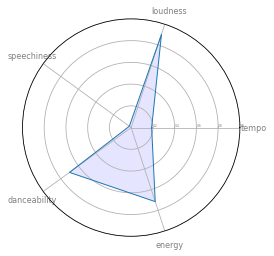

In [29]:
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks( color="grey", size=3)
plt.ylim(0,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Show the graph
plt.show()

### Mood 
        plotting energy vs valence
        high energy, valence = happy
        low energy, valence = sad
        high energy, low valence = angsty
        low energy, high valence = chill

In [47]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=af.valence, y=af.energy,
                    mode='markers',
                    name='markers',
                        showlegend=False,
                        marker = dict(color='#d2e174')
                        ))
fig.add_shape(type='line',
                x0=0,
                y0=0.5,
                x1=1,
                y1=0.5,
                line=dict(color='#afdfdd',),
                xref='x',
                yref='y'
)

fig.add_shape(type='line',
                x0=0.5,
                y0=0,
                x1=0.5,
                y1=1,
                line=dict(color='#afdfdd',),
                xref='x',
                yref='y'
)

#Add 4 song annotations
fig.add_trace(go.Scatter(
    x=[0.939, 0.0849, 0.123,0.67],
    y=[.927,0.339,0.72,0.225],
    mode='markers+text',
    text=['Champagne Night <br> Lady A','Sour <br> Olivia Rodrigo',
         'Hit Bout It <br> Lil Yachty<br> Kodak Black','Better Together <br>Luke Combs'],
    textposition=['top center', 'bottom center','top center','bottom center'],
    showlegend = False,
    marker = dict(color = '#ec5b68',)

))

fig.add_trace(go.Scatter(
    x=[.8,0.2,0.2,0.8],
    y=[1,0,1,0],
    mode='text',
    text=['Happy','Sad','Angry/Angsty','Peaceful'],
    textposition='top center',
    textfont=dict(
        size=16),
    showlegend=False
))

fig.show()

import chart_studio.plotly as py
py.plot(fig, filename = '2021_audiofeatures', auto_open=True)


'https://plotly.com/~zylstraa/19/'

In [41]:
# af[(af.valence ==0.939) & (af.energy==0.927)] #happy Champagne Night Lady A spotify:track:48F2xnWq3LuzYWML327Z2r
# af[(af.valence ==0.0849) & (af.energy==0.339)] #sad Sour Olivia Rodrigo spotify:track:5CZ40GBx1sQ9agT82CLQCT
# af[(af.valence ==0.123) & (af.energy==0.72)] #angry/angsty Hit Bout It by Lil Yachty, Kodak Black spotify:track:6SN1H9p6A0UbsNpfkxEEX6
# af[(af.valence ==0.67) & (af.energy==0.225)] #peaceful Better Together Luke Combs spotify:track:6gdLyYNuhWBzqwlOFSsXC7

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
18,0.552,0.225,0,-11.501,1,0.0477,0.827,0.0,0.111,0.67,138.002,audio_features,6gdLyYNuhWBzqwlOFSsXC7,spotify:track:6gdLyYNuhWBzqwlOFSsXC7,https://api.spotify.com/v1/tracks/6gdLyYNuhWBz...,https://api.spotify.com/v1/audio-analysis/6gdL...,219573,4


### Composition

Might make a graphic of the following below in PhotoShop

In [31]:
af['mode'].value_counts() #1 is major key, 0 is minor key

1    178
0    118
Name: mode, dtype: int64

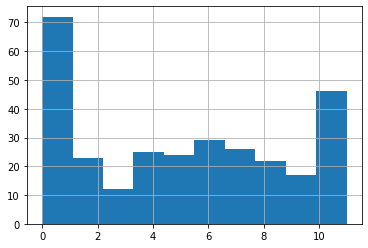

In [32]:
af.key.hist() # 0 is C, 11 is B

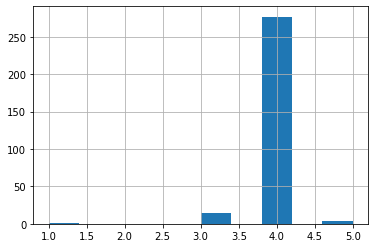

In [33]:
af.time_signature.hist() #okay it's almost always in 4/4 time

In [34]:
af.duration_ms.describe() #3.5 to 4 minutes is the sweet spot

count       296.000000
mean     194899.834459
std       42428.678257
min       63060.000000
25%      169176.000000
50%      190505.000000
75%      216093.000000
max      383037.000000
Name: duration_ms, dtype: float64

In [35]:
ac = af[af.acousticness >= 0.7].sort_values(by='acousticness')#tried various cut off points and 0.7 seems to be the most accurate
len(ac)/len(af)*100 # only 2% are acoustic

6.756756756756757

In [36]:
ins = af[af.instrumentalness > 0.5].sort_values(by='instrumentalness') #it seems anything above 0.5 is mostly instrumental
len(ins)/len(af)*100 # only 0.4% are mostly instrumental

0.33783783783783783